In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import pearsonr

## SICK similarity task data

The [SemEval](http://alt.qcri.org/semeval2016/) data are obtained from the `datasets-sts` repo: https://github.com/brmson/dataset-sts

`pysts` (included in this repo) can be used to load SICK task data.

In [2]:
import sys
sys.path.append('./dataset-sts/')

In [3]:
import pysts
from pysts.loader import load_sts

In [4]:
sickA, sickB, relatedness_score = pysts.loader.load_sick2014('dataset-sts/data/sts/sick2014/SICK_train.txt',
                                                             mode='relatedness')

In [5]:
sickA[0]

['A',
 'group',
 'of',
 'kids',
 'is',
 'playing',
 'in',
 'a',
 'yard',
 'and',
 'an',
 'old',
 'man',
 'is',
 'standing',
 'in',
 'the',
 'background']

In [6]:
sickB[0]

['A',
 'group',
 'of',
 'boys',
 'in',
 'a',
 'yard',
 'is',
 'playing',
 'and',
 'a',
 'man',
 'is',
 'standing',
 'in',
 'the',
 'background']

In [7]:
relatedness_score[0]

4.5

## GloVe pre-trained word vectors 

GloVe - Global Vectors for Word Representation (https://nlp.stanford.edu/projects/glove/). Pre-trained word vectors have been downloaded (we use the 300-dimensional vectors trained on the 840 billion token Common Crawl corpus: http://nlp.stanford.edu/data/glove.840B.300d.zip), and converted to a dictionary for further usage:
    
    import pandas as pd
    import zipfile
    
    z = zipfile.ZipFile("./glove.840B.300d.zip")
    glove = pd.read_csv(z.open('glove.840B.300d.txt'), sep=" ", quoting=3, header=None, index_col=0)
    glove2 = {key: val.values for key, val in glove.T.items()}
    
    import pickle
    with open('glove.840B.300d.pkl', 'wb') as output:
        pickle.dump(glove2, output)

In [8]:
import pickle

In [9]:
with open('glove.840B.300d.pkl', 'rb') as pkl:
    glove = pickle.load(pkl)

## Sentence embedding

See the [sts_tasks.ipynb](sts_tasks.ipynb) notewaybook for an exploration of the different ways to obtain the sentence embedding. The resulting code is put in a sklearn-like transformer in [wordembeddings.py](files/wordembeddings.py), which we use here:

In [10]:
from wordembeddings import EmbeddingVectorizer

In [11]:
emb = EmbeddingVectorizer(word_vectors=glove, weighted=True, R=True)

In [12]:
Vs0 = emb.fit_transform(sickA)
Vs1 = emb.fit_transform(sickB)

In [13]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

## Unsupervized

Not training a model, but just using the computed sentence embeddings, we already get a decent correlation:

In [14]:
predicted = np.array([cosine_similarity(vs0, vs1) for vs0, vs1 in zip(Vs0, Vs1)])

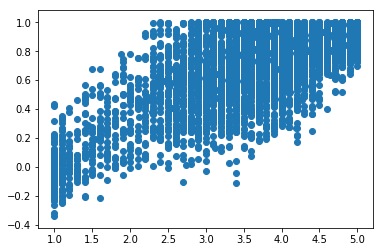

In [15]:
plt.scatter(relatedness_score, predicted);

In [16]:
pearsonr(predicted, relatedness_score)[0]

0.72494726423848554

## Supervized neural network (from paper)

We could further improve this by learning a model to predict the similarity instead of using the distance between both sentence vectors.

Here, we implement using Keras a model similar to the one described in Wieting *et al.*, 2016 (https://arxiv.org/pdf/1511.08198.pdf)

In [17]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate

Using TensorFlow backend.


In [18]:
g1_dot_g2 = Vs0 * Vs1
g1_abs_g2 = np.abs(Vs0 - Vs1)

In [19]:
lin_dot = Input(shape=(300,), name='lin_dot')
lin_abs = Input(shape=(300,), name='lin_abs')

l_sum = concatenate([lin_dot, lin_abs])
l_sigmoid = Dense(50, activation='sigmoid')(l_sum)
l_softmax = Dense(5, activation='softmax')(l_sigmoid)

model = Model(inputs=[lin_dot, lin_abs], outputs=l_softmax)

Convert 1.0 - 5.0 score to sparse matrix:

In [20]:
def to_float_dummies(scores, integer_scores):
    
    diffs = scores[:, np.newaxis] - integer_scores[np.newaxis, :]

    diffs[np.abs(diffs) > 1] = 0
    mask1 = (diffs < 0).copy()
    mask2 = (diffs > 0).copy()
    diffs[mask1] = 1 - np.abs(diffs[mask1]) 
    diffs[mask2] = 1 - diffs[mask2]

    diffs[scores[:, np.newaxis] == integer_scores[np.newaxis, :]] = 1
    
    return diffs

In [21]:
y = to_float_dummies(relatedness_score, np.array([1,2,3,4,5]))

In [22]:
y

array([[ 0. ,  0. ,  0. ,  0.5,  0.5],
       [ 0. ,  0. ,  0.8,  0.2,  0. ],
       [ 0. ,  0. ,  0. ,  0.3,  0.7],
       ..., 
       [ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.8,  0.2,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ]])

In [23]:
np.all((y * np.array([[1, 2, 3, 4, 5]])).sum(axis=1) == relatedness_score)

True

In [24]:
np.all(np.dot(y, np.array([1, 2, 3, 4, 5])) == relatedness_score)

True

In [25]:
from keras.optimizers import Adam

In [26]:
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

In [27]:
model.fit([g1_dot_g2, g1_abs_g2], y, epochs=15)

Epoch 1/15
4500/4500 [==============================] - 0s - loss: 0.9759 - acc: 0.3453     
Epoch 2/15
4500/4500 [==============================] - 0s - loss: 0.8376 - acc: 0.4144     
Epoch 3/15
4500/4500 [==============================] - 0s - loss: 0.7852 - acc: 0.4471     
Epoch 4/15
4500/4500 [==============================] - 0s - loss: 0.7502 - acc: 0.4658     
Epoch 5/15
4500/4500 [==============================] - 0s - loss: 0.7240 - acc: 0.4849     
Epoch 6/15
4500/4500 [==============================] - 0s - loss: 0.7042 - acc: 0.4958     
Epoch 7/15
4500/4500 [==============================] - 0s - loss: 0.6872 - acc: 0.5049     
Epoch 8/15
4500/4500 [==============================] - 0s - loss: 0.6736 - acc: 0.5096     
Epoch 9/15
4500/4500 [==============================] - 0s - loss: 0.6602 - acc: 0.5291     
Epoch 10/15
4500/4500 [==============================] - 0s - loss: 0.6499 - acc: 0.5296     
Epoch 11/15
4500/4500 [==============================] - 0s - loss: 0

In [28]:
predicted = model.predict([g1_dot_g2, g1_abs_g2])

In [29]:
pred_score = np.dot(predicted, np.array([1,2,3,4,5]))

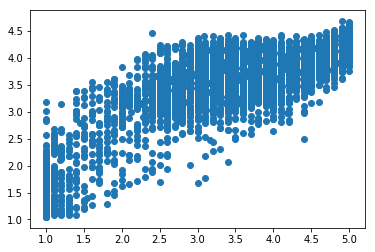

In [30]:
plt.scatter(relatedness_score, pred_score);

In [31]:
pearsonr(pred_score, relatedness_score)[0] * 100

79.287432399070525

### Validate on the test data

In [32]:
sick_testA, sick_testB, relatedness_score_test = \
    pysts.loader.load_sick2014('dataset-sts/data/sts/sick2014/SICK_test_annotated.txt',
                               mode='relatedness')

In [33]:
relatedness_score_test.shape

(4927,)

In [34]:
Vs0_test = emb.fit_transform(sick_testA)
Vs1_test = emb.fit_transform(sick_testB)

Unsupervised:

In [35]:
predicted = np.array([cosine_similarity(vs0, vs1) for vs0, vs1 in zip(Vs0_test, Vs1_test)])
pearsonr(predicted, relatedness_score_test)[0]

0.7136331262835478

Supervised:

In [36]:
g1_dot_g2 = Vs0_test * Vs1_test
g1_abs_g2 = np.abs(Vs0_test - Vs1_test)

In [37]:
predicted = model.predict([g1_dot_g2, g1_abs_g2])

In [38]:
pred_score = np.dot(predicted, np.array([1,2,3,4,5]))

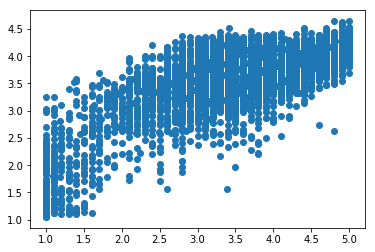

In [40]:
plt.scatter(relatedness_score_test, pred_score);

In [41]:
pearsonr(pred_score, relatedness_score_test)[0] * 100

76.893976028156047

So the simple model improves the score slightly compared to the score without applying a supervised model. In the paper, a score of 84.6 is obtained, but we didn't do any hyperparameter optimization here.

## Supervized neural netword with sklearn

In [42]:
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor

In [43]:
X = np.concatenate([Vs0 * Vs1, np.abs(Vs0, Vs1)], axis=1)

In [44]:
X.shape

(4500, 600)

In [45]:
scaler = StandardScaler()  

In [46]:
X = scaler.fit_transform(X)  

In [69]:
mlp = MLPRegressor(activation='logistic', solver='adam', hidden_layer_sizes=50, early_stopping=True)

In [70]:
mlp.fit(X, relatedness_score)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [71]:
predicted = mlp.predict(X)

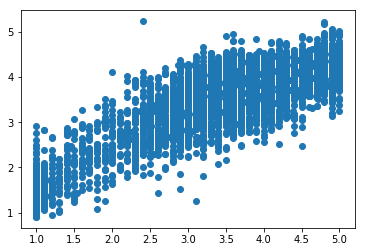

In [72]:
plt.scatter(relatedness_score, predicted);

In [73]:
pearsonr(predicted, relatedness_score)[0] * 100

82.06179723342899

Validate on the test data:

In [74]:
X_test = np.concatenate([Vs0_test * Vs1_test, np.abs(Vs0_test, Vs1_test)], axis=1)

In [75]:
X_test = scaler.transform(X_test)

In [76]:
predicted = mlp.predict(X_test)

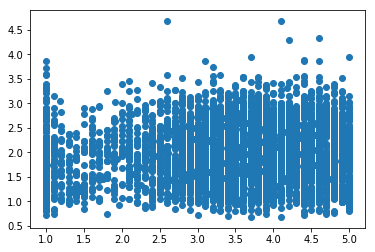

In [77]:
plt.scatter(relatedness_score_test, predicted);

In [78]:
pearsonr(predicted, relatedness_score_test)[0] * 100

6.342303557788723

So the model does not perform well at all on the validation data.

It seems that **using the Kullback-Leibler divergence as the loss function for this specific case works a lot better** (when changing the loss function in the Keras model to softmax, it also performs much worse).

A (very basic) grid search only improves it slightly:

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [81]:
model = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(early_stopping=True))])

In [82]:
grid = GridSearchCV(model, param_grid=dict(mlp__activation=['relu', 'logistic'],
                                           mlp__hidden_layer_sizes=[20, 50, 100, 200],
                                           mlp__alpha=[0.001, 0.0001, 0.00001]))

In [83]:
X = np.concatenate([Vs0 * Vs1, np.abs(Vs0, Vs1)], axis=1)

In [84]:
grid.fit(X, relatedness_score)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'mlp__activation': ['relu', 'logistic'], 'mlp__hidden_layer_sizes': [20, 50, 100, 200], 'mlp__alpha': [0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [85]:
grid.best_params_

{'mlp__activation': 'logistic',
 'mlp__alpha': 0.0001,
 'mlp__hidden_layer_sizes': 200}

In [86]:
grid.best_score_

-0.091228410931032844

In [87]:
pred_best = grid.best_estimator_.predict(X)

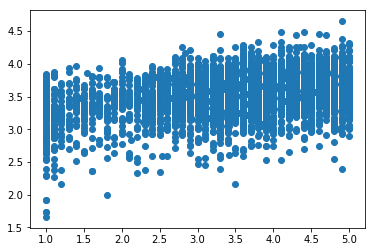

In [88]:
plt.scatter(relatedness_score, pred_best);

In [89]:
pearsonr(pred_best, relatedness_score)[0] * 100

35.623650287940514

In [90]:
X_test = np.concatenate([Vs0_test * Vs1_test, np.abs(Vs0_test, Vs1_test)], axis=1)

In [91]:
pred_best = grid.best_estimator_.predict(X_test)

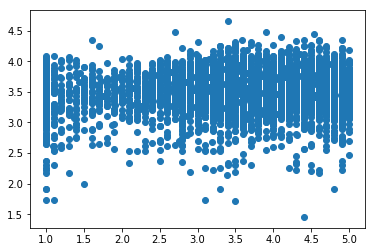

In [92]:
plt.scatter(relatedness_score_test, pred_best);

In [93]:
pearsonr(pred_best, relatedness_score_test)[0] * 100

13.00808081232441